# Lekce 14: Nelineární metody nejmenších čtverců

Nejdříve načtěme nutné balíčky a funkce z minulé hodiny.

In [1]:
using Random
using LinearAlgebra
using Plots

include("utilities.jl")

function grad_descent(grad, x; α=1e-1, max_iter=100, ϵ_tol=1e-6)
    res = zeros(max_iter)
    x_all = zeros(length(x), max_iter)
    for i in 1:max_iter
        x_all[:,i] .= x
        x -= α*grad(x)
        res[i] = norm(grad(x))
        if norm(grad(x)) <= ϵ_tol
            res = res[1:i]
            x_all = x_all[:,1:i]
            break
        end
    end
    return x, x_all, res
end

function newton(grad, hess, x; max_iter=100, ϵ_tol=1e-12)
    res = zeros(max_iter)
    x_all = zeros(length(x), max_iter)
    for i in 1:max_iter
        x_all[:,i] .= x
        x -= hess(x) \ grad(x)
        res[i] = norm(grad(x))
        if norm(grad(x)) <= ϵ_tol
            res = res[1:i]
            x_all = x_all[:,1:i]
            break
        end
    end
    return x, x_all, res
end;

# Nejmenší čtverce

Úkolem dnešní hodiny bude nafitovat $n$ dvojic vzorků $(x_i, y_i)$ pomocí lineárních a nelineárních funkcí. Data $x_i$ budou rovnoměrně rozdělené na intervalu $[-2,2]$ a budeme uvažovat přesnou závislost $$y_i = \sin x_i - 0.1x_i + 1.$$ Důležité je si uvědomit, že tato funkce je neznámá, a tedy ji nemůžeme použít pro transformaci dat $x_i$. Při řešení se parametrizuje prostor hledaných predikcí pomocí nějaké funkce $h(w;x)$. Zde je důležité si uvědomit rozdíl mezi parametry: zatímco $x$ jsou vstupní data, $w$ jsou parametry, které budeme optimalizovat. Poté řešíme optimalizační úlohu $$\operatorname{minimalizuj}\qquad \frac 1n\sum_{i=1}^n (h(w;x_i) - y_i)^2$$ přes všechny možné parametry $w$. Chceme tedy minimalizovat vzdálenost mezi predikcí $h(w;x_i)$ a labelem $y_i$.

# Lineární nejmenší čtverce

Vzhledem k tomu, že máme jednorozměrný vstup $x$, pro lineární nejmenší čtverce máme $$h(w;x) = w_1x + w_2.$$ Lineární nejmenší čtverce potom mají známý tvar $$\operatorname{minimalizuj}\qquad \frac {1}{2n}\sum_{i=1}^n (w_1x_i + w_2 - y_i)^2.$$

Vytvořme nejdříve data a vykresleme je.

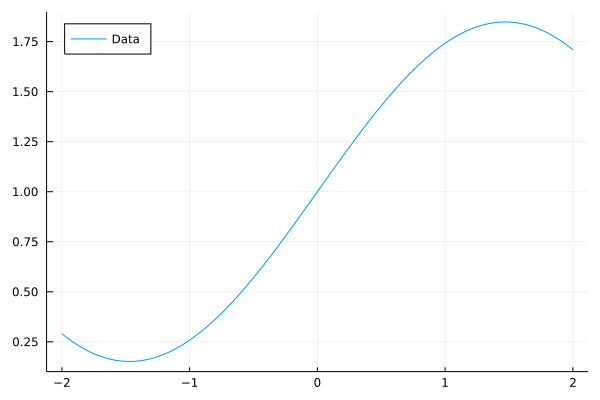

In [2]:
n = 1000
xs = range(-2, 2; length=n)
ys = sin.(xs) .- 0.1*xs .+ 1

plot(xs, ys, label="Data", legend=:topleft)

Nyní zadefinujme funkce se stejným značením jako na přednášce. Nejprve $$g_i(w) = w_1x_i + w_2 - y_i$$ ukazuje chybu při fitu i-tého vzorku. Poté $$f(w) = \frac {1}{2n}\sum_{i=1}^n g_i(w)^2$$ ukazuje průměrnou kvadratickou chybu přes všechny vzorky. Je důležité si uvědomit, že proměnná $x$ už označuje vstupní data, a tedy pro optimalizovanou proměnnou musíme použít jiné písmeno, například $w$. Nyní tyto funkce zadefinujeme. Použijeme maticový zápis s maticí $A$. Zároveň spočteme gradienty $f$ i $g$.

In [3]:
A = hcat(xs, ones(n))

g(w) = A*w .- ys
g_grad(w) = A

f(w) = g(w)'*g(w) / (2*length(g(w)))
f_grad(w) = g_grad(w)'*g(w) / length(g(w))

f(x::Real,y::Real) = f([x,y]);

Lineární nejmenší čtverce minimalizují funkci $f$. Vykresleme tedy její vrstevnice. Znovu si uvědomme, že optimalizujeme přes proměnnou $w$.

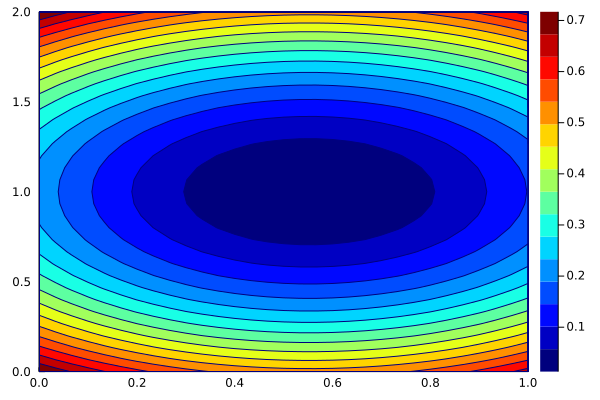

In [4]:
w1lim = range(0, 1; length=31)
w2lim = range(0, 2; length=31)

contourf(w1lim, w2lim, f; color=:jet)

Lineární nejmenší čtverce mají řešení v uzavřené formě $w=(A^\top A)^{-1}A^\top y$. Když toto řešení spočteme a vykreslíme, není překvapivé, že se nachází v minimum funkce $f$.

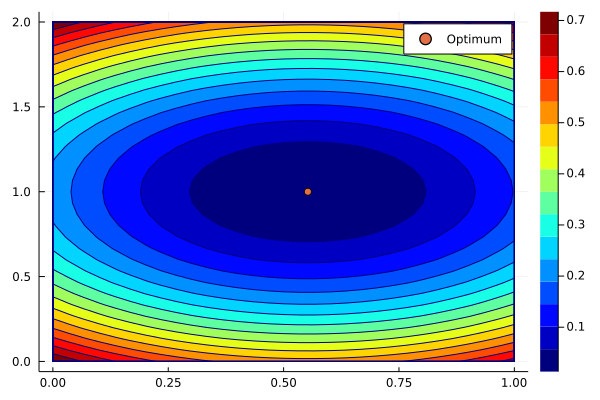

In [5]:
w_opt1 = (A'*A) \ (A'*ys)

contourf(w1lim, w2lim, f; color=:jet)
scatter!([w_opt1[1]], [w_opt1[2]]; label="Optimum")

# Odbočka k řešení soustavy lineárních rovnic

Pro řešení jsme použili neznámý zápis `(A'*A) \ (A'*ys)`. Tento příkaz dá stejný výsledek jako `inv(A'*A)*A'*y`. Rozdíl mezi nimi je ten, že zatímco první příkaz používá specializované algoritmy pro řešení rovnic, druhý nejdrív spočte inverzi matice a teprve potom ji vynásobí vektorem. Ukažme nyní, jak se tyto přístupy liší. Vygenerujme náhodnou řídkou matici `aux_A1` a poté ji přetransformujme do husté matice.

In [6]:
using SparseArrays

aux_s = 1000

aux_A1 = sprandn(aux_s, aux_s, 0.001)
aux_A1 += I
aux_A2 = Matrix(aux_A1);
aux_b = randn(aux_s);

Následující kód ukazuje, že `inv(aux_A2)*aux_b` a `aux_A2\aux_b` dává stejný výsledek.

In [7]:
using LinearAlgebra

norm(inv(aux_A2)*aux_b - aux_A2\aux_b)

5.570179836915261e-14

Udělejme nyní časové porovnání pomocí balíku `BenchmarkTools`.

In [8]:
import BenchmarkTools: @btime

println("Dense matrix based on inv(A)*b")
@btime inv($aux_A2) * $aux_b;

println("Dense matrix based on A \\ b")
@btime $aux_A2 \ $aux_b;

println("Sparse matrix based on A \\ b")
@btime $aux_A1 \ $aux_b;

Dense matrix based on inv(A)*b
  34.593 ms (6 allocations: 8.13 MiB)
Dense matrix based on A \ b
  15.386 ms (4 allocations: 7.64 MiB)
Sparse matrix based on A \ b
  249.300 μs (65 allocations: 608.67 KiB)


Vidíme, že syntaxe `A \ b` je několikrát rychlejší a má menší nároky na paměť. Při použití řídké matice je rozdíl ještě markantnější, neboť `inv(A)` generuje hustou matici a není schopné využít řídkosti.

# Lineární nejmenší čtverce podruhé

Z minulé hodiny máme naprogramovaný gradient descent. Pustíme ho tedy stejně jako minule.

In [9]:
w0 = [0;0]

w_opt2, w_all2, res2 = grad_descent(f_grad, w0);

Dostali jsme optimální parametry, ale zajímá nás predikce. Tu dostaneme jako $w_1x+w_2$. Po vykreslení dostaneme nejlepší lineární aproximaci, která ale není moc dobrá.

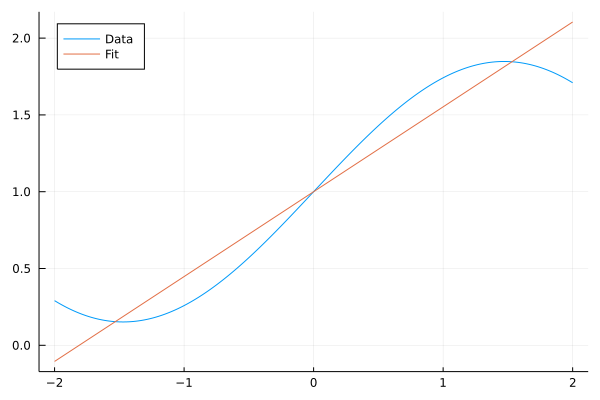

In [10]:
plot(xs, ys, label="Data", legend=:topleft)
plot!(xs, x -> w_opt2[1]*x + w_opt2[2], label="Fit")

Použijme opět stejnou funkci jako na minulé hodině a vykresleme konvergenci iterací.

In [11]:
create_anim(f, w_all2, w1lim, w2lim, "Anim_NC1.gif");

![](Anim_NC1.gif)

# Metody založené na Newtonově metodě

Pro použití Gauss-Newtonovy and Levenberg-Marquardtovy metody je dobré si uvědomit, že obě pracují stejně jako Newtonova metoda, tedy krok je $-A^{-1}\nabla f(x)$ pro nějakou matici $A$. Pro Newtonovu metodu se za $A$ bere Hessián, zatímco pro dvě výše zmíněné metoda to je nějaká jeho aproximace. Není tedy nutné psát novou optimalizační funkci, ale stačí použit již napsanou funkci `newton` se správným vstupem `h` druhých derivací. Tyto derivace jde spočíst následovně:

In [12]:
f_hess_approx(w,λ) = g_grad(w)'*g_grad(w) / length(g(w)) + λ*Diagonal(ones(length(w)));

Gauss-Newtonova metoda používá `μ=0`, zatímco Levenberg-Marquardtova metoda používá `μ>0`. Poté již stačí zavolat Newtonovu metodu a dostaneme řešení.

In [13]:
w_opt3, w_all3, res3 = newton(f_grad, w -> f_hess_approx(w, 0), w0)
w_opt4, w_all4, res4 = newton(f_grad, w -> f_hess_approx(w, 0.5), w0);

Je dobré si uvědomit, že Gauss-Newtonova metoda je přesná Newtonova metoda, neboť druhá derivace `g` je nulová. Vzhledem k tomu, že `f` je kvadratická, pro `w_opt3` dostáváme konvergenci v jedné iteraci. Pro Levenberg-Marquardtovu metodu je konvergence pomalejší. Navíc perturbace Hessiánu změnila superlineární (rychlou) konvergenci na pouhou lineární konvergenci.

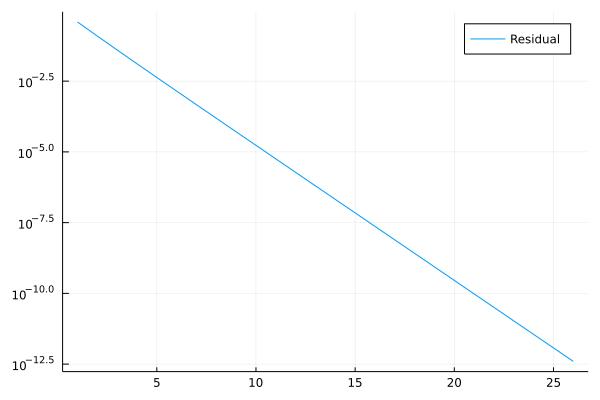

In [14]:
plot(res4; yscale=:log10, label="Residual")

Nakonec opět vykresleme jednotlivé iterace.

In [15]:
create_anim(f, w_all4, w1lim, w2lim, "Anim_NC2.gif");

![](Anim_NC2.gif)

# Stochastický gradient descent

Pro stochastický gradient descent definujme funkce stejně jako v první části přednášky, ale uvažujme pouze vzorky v nějaké indexové množině $I$. To odpovídá tomu, že uvažujeme pouze ty řádky matice $A$, které odpovídají těmto indexům.

In [16]:
g(w, I) = A[I,:]*w - ys[I]
g_grad(w, I) = A[I,:]

f(w, I) = g(w, I)'*g(w, I) / (2*length(g(w, I)))
f_grad(w, I) = g_grad(w, I)'*g(w, I) / length(g(w, I));

Stochastický gradient descent je stejný jako standardní gradient descent, ale gradient počítáme pouze ze zmenšeného počtu vzorků. Největší výhoda stochastického gradientu je rychlost počítání, neboť se pracuje pouze s malým počtem vzorků.

In [17]:
function stoch_grad_descent(grad, x, n; n_minibatch=8, α=1e-1, max_iter=100)
    res1 = zeros(max_iter)
    res2 = zeros(max_iter)
    x_all = zeros(length(x), max_iter)
    for i in 1:max_iter
        x_all[:,i] = x
        I = randperm(n)[1:n_minibatch]
        x -= α*grad(x, I)
        res1[i] = norm(grad(x, I))
        res2[i] = norm(grad(x, 1:n))
    end
    return x, x_all, res1, res2
end;

Pusťme nyní stochastický gradient descent.

In [18]:
w_opt5, w_all5, res5_1, res5_2 = stoch_grad_descent(f_grad, w0, n);

Dále pak vykresleme rezidua na minibatchi a na celém souboru. Vidíme, že rezidua na minibatchi velmi skáčou. Důvod je ten, že minibatch je malý, což přidává nestabilitu.

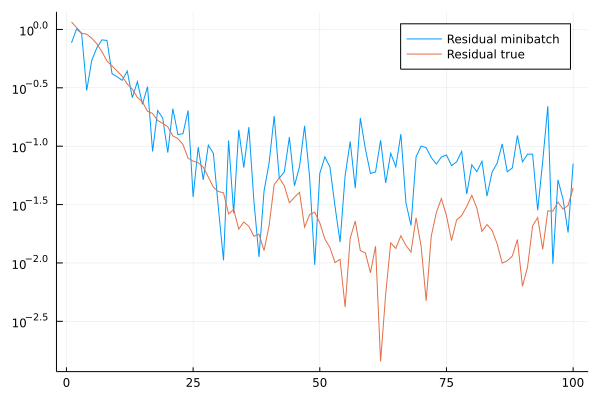

In [19]:
plot(res5_1; yscale=:log10, label="Residual minibatch")
plot!(res5_2; yscale=:log10, label="Residual true")

Iterace konvergují zpočátku rychle, ale když se dostanou poblíž řešení, tak začnou skákat. Důvodem je opět malá velikost minibatche. Pro konvergenci by bylo potřeba snižovat délku kroku.

In [20]:
create_anim(f, w_all5, w1lim, w2lim, "Anim_NC3.gif")

![](Anim_NC3.gif)

I když jsme nedokonvergovali, následující obrázek ukazuje, že jsme pořád blízko dobrého řešení.

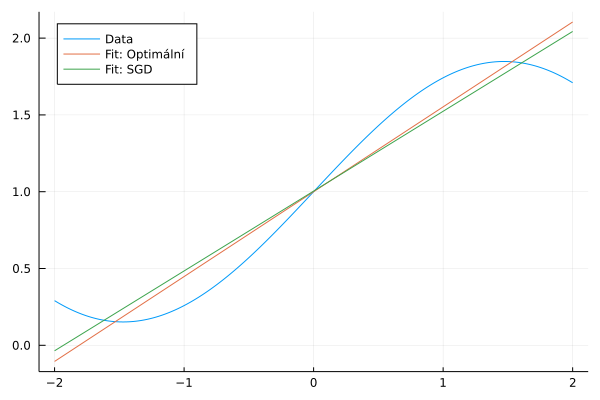

In [21]:
plot(xs, ys, label="Data", legend=:topleft)
plot!(xs, x -> w_opt2[1]*x + w_opt2[2], label="Fit: Optimální")
plot!(xs, x -> w_opt5[1]*x + w_opt5[2], label="Fit: SGD")

# Nelineární nejmenší čtverce

Ukážeme si nyní, jak nafitovat onu sinusoidu pomocí jednoduché neuronové sítě. Neuronová síť není nic jiného než nelineární zobrazení s nějakým speciálním předpisem. Načtěme nejdříve nutné balíky.

In [22]:
using Flux
using Flux: mse
using Base.Iterators: partition

Vzhledem k tomu, že balík Flux vyžaduje, aby poslední dimenze vstupů byly vzorky, tak musíme vstupná data transformovat do řádkového vektoru. Zároveň je kvůli rychlostem výpočtu konvertujeme z `Float64` do `Float32`.

In [23]:
xs_row = Float32.(reshape(xs,1,:))
ys_row = Float32.(reshape(ys,1,:));

Nyní zkonstruujme jednoduchou neuronovou síť s dvěma skrytými vrstvami.

In [24]:
n_hidden = 10
m = Chain(
    Dense(1, n_hidden, relu),
    Dense(n_hidden, n_hidden, relu),
    Dense(n_hidden, 1),
);

Zadefinujme účelovou funkci jako mean square error, vytáhněme ze sítě parametry (které na začátku byly označeny jako $w$) a jako optimalizátor použijme gradient descent.

In [25]:
loss(x, y) = mse(m(x), y)
ps = params(m)
opt = Descent(1e-1);

Nyní udělejme 100 iterací gradient descentu. Všimněme si, že Flux automaticky počítá derivace a provádí update parametrů.

In [26]:
max_iter = 100

Ls1 = zeros(max_iter)
for i in 1:max_iter
    gs = gradient(ps) do
        loss(xs_row, ys_row)
    end

    Flux.update!(opt, ps, gs)
    Ls1[i] = loss(xs_row, ys_row)
end

Po vykreslení vidíme, že máme docela dobrý fit.

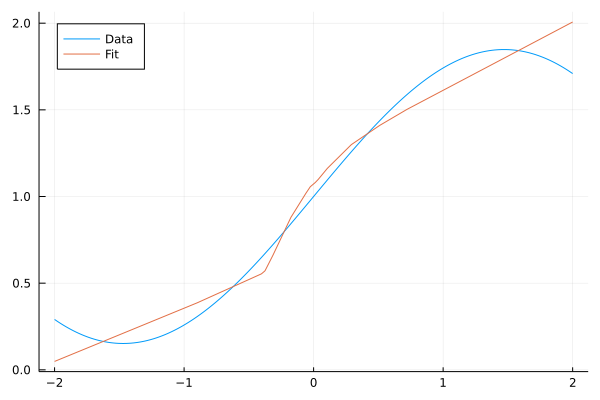

In [27]:
plot(xs, ys, label="Data", legend=:topleft)
plot!(xs, m(xs_row)[:], label="Fit")

Nyní udělejme to samé, ale se stochastickým gradient descentem. Protože model `m` si v sobě nese optimalizované parametry, tak ho nejdříve znovu inicializujme.

In [28]:
m = Chain(
    Dense(1, n_hidden, relu),
    Dense(n_hidden, n_hidden, relu),
    Dense(n_hidden, 1),
);

Nyní udělejme iterátor, který všechny vzorky rozdělí do minibachů, kde každý minibatch má velikost 10 vzorků.

In [29]:
batch_size = 10
batches_train = map(partition(randperm(size(ys_row, 2)), batch_size)) do inds
    return (xs_row[:, inds], ys_row[:, inds])
end;

Pusťme stochastický gradient descent na 100 epoch. V jedné epoše by se optimalizátor měl podívat na každý vzorek právě jednou. Vzhledem k tomu, že máme 1000 dat a minibatch je velikosti 10, tak za 100 epoch uděláme 10000 gradientních updatů. Stochastický gradient tedy za stejný čas udělá daleko více updatů než gradient descent. I když jsou tyto updaty nepřesné, tak rychlostní bonus je většinou tak výrazný, že je dobré stochastickou verzi uvažovat.

In [30]:
Ls2 = zeros(max_iter)
for i in 1:max_iter
    Flux.train!(loss, params(m), batches_train, opt)
    Ls2[i] = loss(xs_row, ys_row)
end

Porovnejme nyní běžný a stochastický gradient descent. Vidíme, že stochastická varianta má výrazně menší ztrátovou funkci.

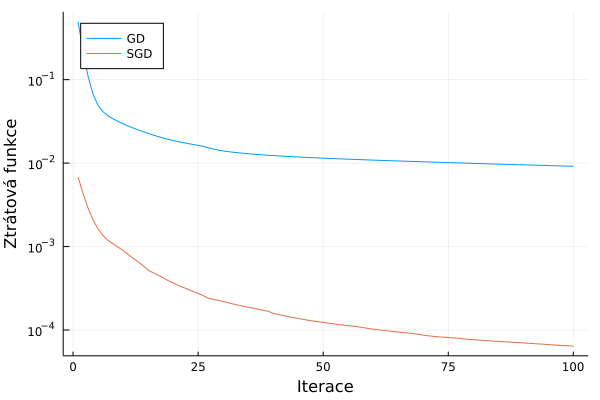

In [31]:
plot(Ls1, label="GD", xlabel="Iterace", ylabel="Ztrátová funkce", legend=:topleft, yscale=:log10)
plot!(Ls2, label="SGD")

Když vykreslíme predikci, dsotáváme skoro perfektní fit. Do odpovídá ne úplně běžné situaci, že stochastický gradient descent dokonvergoval do globálního minima.

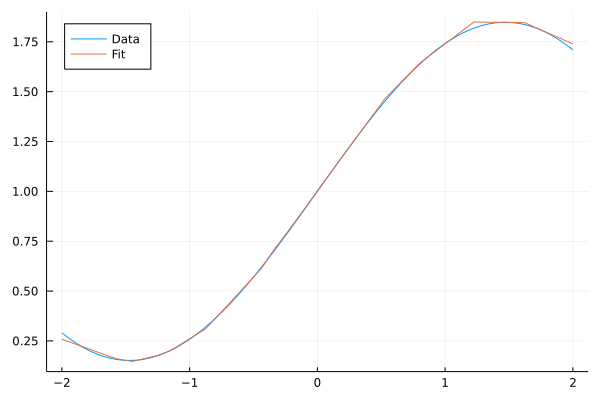

In [32]:
plot(xs, ys, label="Data", legend=:topleft)
plot!(xs, m(xs_row)[:], label="Fit")

Zdálo by se, že všechno je růžové, ale co se stane, když vykreslíme fit mimo obor dat?

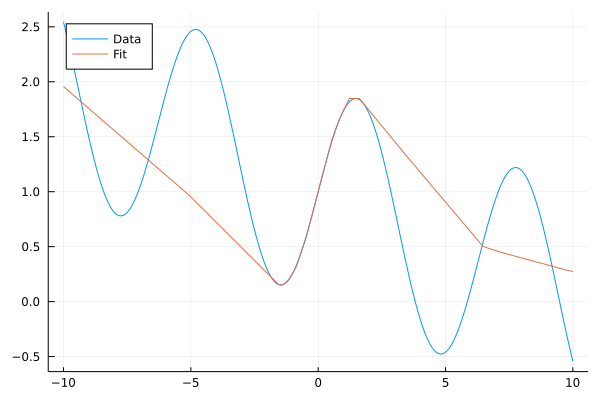

In [33]:
xs_ext = -10:0.01:10
ys_ext = sin.(xs_ext) .- 0.1*xs_ext .+ 1

plot(xs_ext, ys_ext, label="Data", legend=:topleft)
plot!(xs_ext, m(Float32.(reshape(xs_ext,1,:)))[:], label="Fit")

Není vůbec dobrý. Toto je ale vlastnost všech modelů. Když učíme model na datech z intervalu $[-2,2]$ a pak ho testujeme mimo tento interval, nemůžeme očekávat, že tam bude fungovat dobře.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*